In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', 
                      input_shape=input_shape)) 
    model.add(Activation('tanh'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), strides=1, 
                          padding='same'))
        model.add(Activation('tanh'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_21 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_22 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_23 (Activation)   (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7407 - acc: 0.1048
Epoch 00001: val_loss improved from inf to 2.73499, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_1_conv_checkpoint/001-2.7350.hdf5
36805/36805 [==============================] - 29s 795us/sample - loss: 2.7407 - acc: 0.1048 - val_loss: 2.7350 - val_acc: 0.0948
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.5479 - acc: 0.2242
Epoch 00002: val_loss did not improve from 2.73499
36805/36805 [==============================] - 27s 744us/sample - loss: 2.5480 - acc: 0.2241 - val_loss: 2.7947 - val_acc: 0.0995
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3671 - acc: 0.2970
Epoch 00003: val_loss did not improve from 2.73499
36805/36805 [==============================] - 27s 736us/sample - loss: 2.3670 - acc: 0.2971 - val_loss: 

36800/36805 [============================>.] - ETA: 0s - loss: 1.0108 - acc: 0.7045
Epoch 00029: val_loss did not improve from 2.73499
36805/36805 [==============================] - 27s 731us/sample - loss: 1.0108 - acc: 0.7044 - val_loss: 4.9856 - val_acc: 0.1085
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9962 - acc: 0.7093
Epoch 00030: val_loss did not improve from 2.73499
36805/36805 [==============================] - 27s 730us/sample - loss: 0.9961 - acc: 0.7093 - val_loss: 5.0555 - val_acc: 0.1106
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9734 - acc: 0.7169
Epoch 00031: val_loss did not improve from 2.73499
36805/36805 [==============================] - 27s 729us/sample - loss: 0.9734 - acc: 0.7169 - val_loss: 5.1119 - val_acc: 0.1095
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9602 - acc: 0.7196
Epoch 00032: val_loss did not improve from 2.73499
36805/36805 [==================

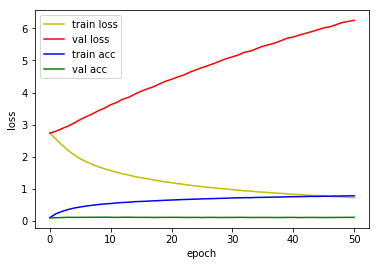

4815/4815 [==============================] - 1s 307us/sample - loss: 2.7278 - acc: 0.1040
Loss: 2.7278172813843344 Accuracy: 0.10404985

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4021 - acc: 0.2403
Epoch 00001: val_loss improved from inf to 2.18306, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_2_conv_checkpoint/001-2.1831.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 2.4022 - acc: 0.2403 - val_loss: 2.1831 - val_acc: 0.3156
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9221 - acc: 0.4019
Epoch 00002: val_loss improved from 2.18306 to 2.05126, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_2_conv_checkpoint/002-2.0513.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.9222 - acc: 0.4019 - val_loss: 2.0513 - val_acc: 0.3559
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5979 - acc: 0.7985
Epoch 00029: val_loss did not improve from 2.05113
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.5979 - acc: 0.7985 - val_loss: 3.0082 - val_acc: 0.3648
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5832 - acc: 0.8048
Epoch 00030: val_loss did not improve from 2.05113
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.5833 - acc: 0.8047 - val_loss: 3.0853 - val_acc: 0.3638
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5795 - acc: 0.8063
Epoch 00031: val_loss did not improve from 2.05113
36805/36805 [==============================] - 41s 1ms/sample - loss: 0.5796 - acc: 0.8062 - val_loss: 3.0947 - val_acc: 0.3573
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5736 - acc: 0.8069
Epoch 00032: val_loss did not improve from 2.05113
36805/36805 [===========

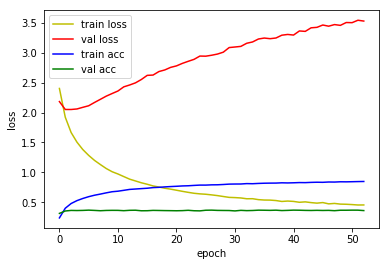

4815/4815 [==============================] - 2s 500us/sample - loss: 2.0843 - acc: 0.3524
Loss: 2.084329318282265 Accuracy: 0.3524403

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1072 - acc: 0.3287
Epoch 00001: val_loss improved from inf to 1.72592, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_3_conv_checkpoint/001-1.7259.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 2.1072 - acc: 0.3287 - val_loss: 1.7259 - val_acc: 0.4587
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5721 - acc: 0.5018
Epoch 00002: val_loss improved from 1.72592 to 1.57960, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_3_conv_checkpoint/002-1.5796.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.5721 - acc: 0.5018 - val_loss: 1.5796 - val_acc: 0.5024
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4725 - acc: 0.8439
Epoch 00028: val_loss did not improve from 1.48949
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.4726 - acc: 0.8439 - val_loss: 1.6126 - val_acc: 0.6073
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4594 - acc: 0.8488
Epoch 00029: val_loss did not improve from 1.48949
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.4595 - acc: 0.8488 - val_loss: 1.6328 - val_acc: 0.6091
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4511 - acc: 0.8499
Epoch 00030: val_loss did not improve from 1.48949
36805/36805 [==============================] - 46s 1ms/sample - loss: 0.4512 - acc: 0.8499 - val_loss: 1.6338 - val_acc: 0.6068
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4351 - acc: 0.8569
Epoch 00031: val_loss did not improve from 1.48949
36805/36805 [===========

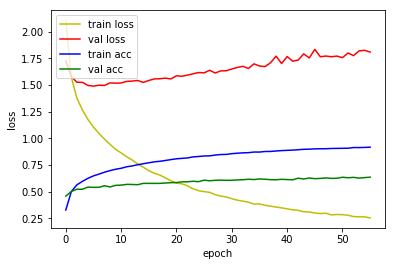

4815/4815 [==============================] - 3s 585us/sample - loss: 1.5735 - acc: 0.5088
Loss: 1.5734667690619748 Accuracy: 0.50882655

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9977 - acc: 0.3514
Epoch 00001: val_loss improved from inf to 1.54585, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_4_conv_checkpoint/001-1.5458.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.9976 - acc: 0.3515 - val_loss: 1.5458 - val_acc: 0.5232
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4979 - acc: 0.5237
Epoch 00002: val_loss improved from 1.54585 to 1.37465, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_4_conv_checkpoint/002-1.3746.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.4980 - acc: 0.5236 - val_loss: 1.3746 - val_acc: 0.5851
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5051 - acc: 0.8389
Epoch 00024: val_loss improved from 0.98508 to 0.97780, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_4_conv_checkpoint/024-0.9778.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.5050 - acc: 0.8390 - val_loss: 0.9778 - val_acc: 0.7186
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4845 - acc: 0.8445
Epoch 00025: val_loss improved from 0.97780 to 0.97130, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_4_conv_checkpoint/025-0.9713.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.4845 - acc: 0.8445 - val_loss: 0.9713 - val_acc: 0.7221
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4761 - acc: 0.8476
Epoch 00026: val_loss improved from 0.97130 to 0.96800, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_4_conv_checkpoint/026-0.9680.hd

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2815 - acc: 0.9083
Epoch 00052: val_loss did not improve from 0.94663
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.2815 - acc: 0.9083 - val_loss: 0.9722 - val_acc: 0.7591
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2736 - acc: 0.9114
Epoch 00053: val_loss did not improve from 0.94663
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2736 - acc: 0.9114 - val_loss: 0.9873 - val_acc: 0.7538
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2765 - acc: 0.9087
Epoch 00054: val_loss did not improve from 0.94663
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2765 - acc: 0.9087 - val_loss: 0.9814 - val_acc: 0.7582
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2719 - acc: 0.9101
Epoch 00055: val_loss did not improve from 0.94663
36805/36805 [===========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2059 - acc: 0.9321
Epoch 00082: val_loss did not improve from 0.94663
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2059 - acc: 0.9321 - val_loss: 1.0029 - val_acc: 0.7734
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2059 - acc: 0.9311
Epoch 00083: val_loss did not improve from 0.94663
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2059 - acc: 0.9311 - val_loss: 1.0136 - val_acc: 0.7727
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2081 - acc: 0.9312
Epoch 00084: val_loss did not improve from 0.94663
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.2081 - acc: 0.9312 - val_loss: 1.0250 - val_acc: 0.7701
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2087 - acc: 0.9303
Epoch 00085: val_loss did not improve from 0.94663
36805/36805 [===========

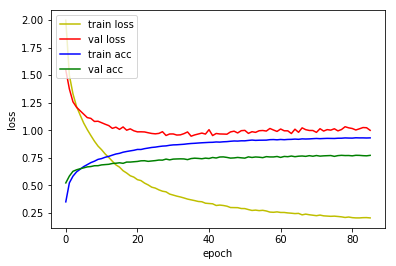

4815/4815 [==============================] - 3s 575us/sample - loss: 1.0243 - acc: 0.7148
Loss: 1.0243151929148262 Accuracy: 0.7148494

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9481 - acc: 0.3655
Epoch 00001: val_loss improved from inf to 1.46738, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_5_conv_checkpoint/001-1.4674.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.9480 - acc: 0.3656 - val_loss: 1.4674 - val_acc: 0.5500
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4802 - acc: 0.5283
Epoch 00002: val_loss improved from 1.46738 to 1.37628, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_5_conv_checkpoint/002-1.3763.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.4802 - acc: 0.5283 - val_loss: 1.3763 - val_acc: 0.5674
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

36800/36805 [============================>.] - ETA: 0s - loss: 0.5338 - acc: 0.8396
Epoch 00024: val_loss improved from 0.74285 to 0.73811, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_5_conv_checkpoint/024-0.7381.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.5338 - acc: 0.8396 - val_loss: 0.7381 - val_acc: 0.7859
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5214 - acc: 0.8436
Epoch 00025: val_loss improved from 0.73811 to 0.73629, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_5_conv_checkpoint/025-0.7363.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.5217 - acc: 0.8436 - val_loss: 0.7363 - val_acc: 0.7880
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5146 - acc: 0.8446
Epoch 00026: val_loss improved from 0.73629 to 0.73245, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_5_conv_checkpoint/026-0.7325.hdf5
36805/3680

36800/36805 [============================>.] - ETA: 0s - loss: 0.3078 - acc: 0.9039
Epoch 00050: val_loss did not improve from 0.69797
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3078 - acc: 0.9039 - val_loss: 0.7083 - val_acc: 0.8099
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3013 - acc: 0.9045
Epoch 00051: val_loss did not improve from 0.69797
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3013 - acc: 0.9046 - val_loss: 0.7407 - val_acc: 0.8039
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2940 - acc: 0.9077
Epoch 00052: val_loss did not improve from 0.69797
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2940 - acc: 0.9077 - val_loss: 0.7417 - val_acc: 0.8053
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2864 - acc: 0.9110
Epoch 00053: val_loss did not improve from 0.69797
36805/36805 [========================

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2105 - acc: 0.9307
Epoch 00080: val_loss did not improve from 0.69797
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2105 - acc: 0.9306 - val_loss: 0.7153 - val_acc: 0.8204
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2057 - acc: 0.9337
Epoch 00081: val_loss did not improve from 0.69797
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2057 - acc: 0.9337 - val_loss: 0.7346 - val_acc: 0.8218
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2118 - acc: 0.9315
Epoch 00082: val_loss did not improve from 0.69797
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2117 - acc: 0.9315 - val_loss: 0.7160 - val_acc: 0.8223
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2050 - acc: 0.9339
Epoch 00083: val_loss did not improve from 0.69797
36805/36805 [===========

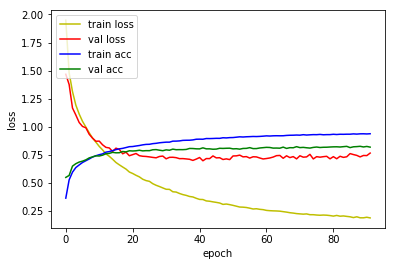

4815/4815 [==============================] - 3s 606us/sample - loss: 0.7704 - acc: 0.7707
Loss: 0.7704321701950002 Accuracy: 0.7707165

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0387 - acc: 0.3228
Epoch 00001: val_loss improved from inf to 1.53020, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_6_conv_checkpoint/001-1.5302.hdf5
36805/36805 [==============================] - 53s 1ms/sample - loss: 2.0386 - acc: 0.3228 - val_loss: 1.5302 - val_acc: 0.5118
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5880 - acc: 0.4806
Epoch 00002: val_loss improved from 1.53020 to 1.34415, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_6_conv_checkpoint/002-1.3442.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.5879 - acc: 0.4806 - val_loss: 1.3442 - val_acc: 0.5940
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s 

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6449 - acc: 0.8084
Epoch 00023: val_loss improved from 0.63138 to 0.62138, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_6_conv_checkpoint/023-0.6214.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.6448 - acc: 0.8084 - val_loss: 0.6214 - val_acc: 0.8232
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6336 - acc: 0.8125
Epoch 00024: val_loss improved from 0.62138 to 0.61085, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_6_conv_checkpoint/024-0.6108.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.6336 - acc: 0.8125 - val_loss: 0.6108 - val_acc: 0.8279
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6171 - acc: 0.8144
Epoch 00025: val_loss did not improve from 0.61085
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.6170 - acc: 0.8145 - val_l

36800/36805 [============================>.] - ETA: 0s - loss: 0.4352 - acc: 0.8687
Epoch 00048: val_loss improved from 0.51759 to 0.51530, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_6_conv_checkpoint/048-0.5153.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.4352 - acc: 0.8687 - val_loss: 0.5153 - val_acc: 0.8595
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4296 - acc: 0.8689
Epoch 00049: val_loss did not improve from 0.51530
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.4296 - acc: 0.8689 - val_loss: 0.5173 - val_acc: 0.8570
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4267 - acc: 0.8723
Epoch 00050: val_loss did not improve from 0.51530
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.4266 - acc: 0.8723 - val_loss: 0.5164 - val_acc: 0.8584
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4239 -

Epoch 75/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3228 - acc: 0.9014
Epoch 00075: val_loss did not improve from 0.48330
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.3227 - acc: 0.9015 - val_loss: 0.5090 - val_acc: 0.8649
Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3289 - acc: 0.8993
Epoch 00076: val_loss improved from 0.48330 to 0.47325, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_6_conv_checkpoint/076-0.4732.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.3289 - acc: 0.8994 - val_loss: 0.4732 - val_acc: 0.8737
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3229 - acc: 0.8996
Epoch 00077: val_loss did not improve from 0.47325
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.3230 - acc: 0.8996 - val_loss: 0.4938 - val_acc: 0.8684
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.2446 - acc: 0.9217
Epoch 00104: val_loss did not improve from 0.47325
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2446 - acc: 0.9217 - val_loss: 0.4818 - val_acc: 0.8765
Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2473 - acc: 0.9225
Epoch 00105: val_loss did not improve from 0.47325
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2473 - acc: 0.9225 - val_loss: 0.4857 - val_acc: 0.8765
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2461 - acc: 0.9223
Epoch 00106: val_loss did not improve from 0.47325
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2461 - acc: 0.9223 - val_loss: 0.4936 - val_acc: 0.8763
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2445 - acc: 0.9208
Epoch 00107: val_loss did not improve from 0.47325
36805/36805 [=====================

Epoch 133/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1973 - acc: 0.9359
Epoch 00133: val_loss did not improve from 0.47278
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1972 - acc: 0.9359 - val_loss: 0.4826 - val_acc: 0.8775
Epoch 134/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2031 - acc: 0.9329
Epoch 00134: val_loss did not improve from 0.47278
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2031 - acc: 0.9329 - val_loss: 0.4785 - val_acc: 0.8791
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1988 - acc: 0.9353
Epoch 00135: val_loss did not improve from 0.47278
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1988 - acc: 0.9353 - val_loss: 0.4883 - val_acc: 0.8779
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1980 - acc: 0.9354
Epoch 00136: val_loss did not improve from 0.47278
36805/36805 [=======

Epoch 163/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1657 - acc: 0.9474
Epoch 00163: val_loss did not improve from 0.47278
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1658 - acc: 0.9473 - val_loss: 0.5099 - val_acc: 0.8779
Epoch 164/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1657 - acc: 0.9460
Epoch 00164: val_loss did not improve from 0.47278
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1657 - acc: 0.9459 - val_loss: 0.4978 - val_acc: 0.8784
Epoch 165/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1643 - acc: 0.9452
Epoch 00165: val_loss did not improve from 0.47278
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1643 - acc: 0.9453 - val_loss: 0.5134 - val_acc: 0.8768
Epoch 166/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1562 - acc: 0.9495
Epoch 00166: val_loss did not improve from 0.47278
36805/36805 [=======

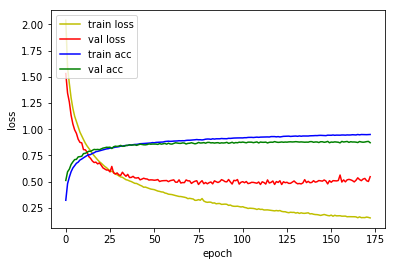

4815/4815 [==============================] - 3s 606us/sample - loss: 0.5956 - acc: 0.8417
Loss: 0.5955511114679022 Accuracy: 0.84174454

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1475 - acc: 0.2919
Epoch 00001: val_loss improved from inf to 1.56204, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_7_conv_checkpoint/001-1.5620.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 2.1474 - acc: 0.2919 - val_loss: 1.5620 - val_acc: 0.5195
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6659 - acc: 0.4546
Epoch 00002: val_loss improved from 1.56204 to 1.35163, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_7_conv_checkpoint/002-1.3516.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.6658 - acc: 0.4547 - val_loss: 1.3516 - val_acc: 0.5940
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4834 - acc: 0.8592
Epoch 00023: val_loss improved from 0.40708 to 0.39637, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_7_conv_checkpoint/023-0.3964.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.4834 - acc: 0.8592 - val_loss: 0.3964 - val_acc: 0.8910
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4718 - acc: 0.8628
Epoch 00024: val_loss improved from 0.39637 to 0.37405, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_7_conv_checkpoint/024-0.3740.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.4718 - acc: 0.8628 - val_loss: 0.3740 - val_acc: 0.8956
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4608 - acc: 0.8639
Epoch 00025: val_loss improved from 0.37405 to 0.36694, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_7_conv_checkpoint/025-0.3669.hd

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2893 - acc: 0.9145
Epoch 00048: val_loss did not improve from 0.28616
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2894 - acc: 0.9145 - val_loss: 0.2936 - val_acc: 0.9182
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2871 - acc: 0.9142
Epoch 00049: val_loss improved from 0.28616 to 0.27209, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_7_conv_checkpoint/049-0.2721.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2871 - acc: 0.9141 - val_loss: 0.2721 - val_acc: 0.9266
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2864 - acc: 0.9157
Epoch 00050: val_loss did not improve from 0.27209
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2864 - acc: 0.9157 - val_loss: 0.2931 - val_acc: 0.9178
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - l

Epoch 76/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1991 - acc: 0.9394
Epoch 00076: val_loss did not improve from 0.25184
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1991 - acc: 0.9394 - val_loss: 0.2536 - val_acc: 0.9331
Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1965 - acc: 0.9400
Epoch 00077: val_loss did not improve from 0.25184
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1965 - acc: 0.9400 - val_loss: 0.2710 - val_acc: 0.9322
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1907 - acc: 0.9424
Epoch 00078: val_loss did not improve from 0.25184
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1907 - acc: 0.9424 - val_loss: 0.2711 - val_acc: 0.9294
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1890 - acc: 0.9421
Epoch 00079: val_loss improved from 0.25184 to 0.24460, saving model to mod

Epoch 105/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1413 - acc: 0.9561
Epoch 00105: val_loss did not improve from 0.24271
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1413 - acc: 0.9561 - val_loss: 0.2585 - val_acc: 0.9369
Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1316 - acc: 0.9592
Epoch 00106: val_loss did not improve from 0.24271
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1316 - acc: 0.9592 - val_loss: 0.2719 - val_acc: 0.9355
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1337 - acc: 0.9585
Epoch 00107: val_loss did not improve from 0.24271
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1337 - acc: 0.9585 - val_loss: 0.2479 - val_acc: 0.9364
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1342 - acc: 0.9586
Epoch 00108: val_loss did not improve from 0.24271
36805/36805 [=======

36800/36805 [============================>.] - ETA: 0s - loss: 0.0979 - acc: 0.9697
Epoch 00134: val_loss did not improve from 0.24118
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0979 - acc: 0.9697 - val_loss: 0.2861 - val_acc: 0.9366
Epoch 135/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0972 - acc: 0.9693
Epoch 00135: val_loss did not improve from 0.24118
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0972 - acc: 0.9694 - val_loss: 0.2814 - val_acc: 0.9369
Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0981 - acc: 0.9679
Epoch 00136: val_loss did not improve from 0.24118
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0982 - acc: 0.9679 - val_loss: 0.2658 - val_acc: 0.9371
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0933 - acc: 0.9714
Epoch 00137: val_loss did not improve from 0.24118
36805/36805 [=====================

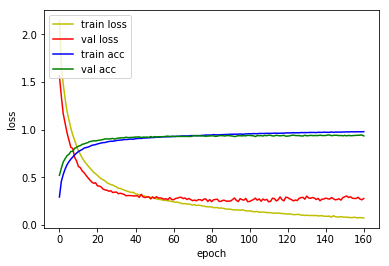

4815/4815 [==============================] - 3s 637us/sample - loss: 0.3216 - acc: 0.9111
Loss: 0.32164603567847583 Accuracy: 0.9111111

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1893 - acc: 0.2773
Epoch 00001: val_loss improved from inf to 1.56677, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_8_conv_checkpoint/001-1.5668.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 2.1893 - acc: 0.2773 - val_loss: 1.5668 - val_acc: 0.5211
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6603 - acc: 0.4605
Epoch 00002: val_loss improved from 1.56677 to 1.23150, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_8_conv_checkpoint/002-1.2315.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.6601 - acc: 0.4606 - val_loss: 1.2315 - val_acc: 0.6513
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2779 - acc: 0.9198
Epoch 00023: val_loss improved from 0.20015 to 0.19014, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_8_conv_checkpoint/023-0.1901.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2778 - acc: 0.9198 - val_loss: 0.1901 - val_acc: 0.9467
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2617 - acc: 0.9242
Epoch 00024: val_loss improved from 0.19014 to 0.18907, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_8_conv_checkpoint/024-0.1891.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2617 - acc: 0.9242 - val_loss: 0.1891 - val_acc: 0.9467
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2523 - acc: 0.9264
Epoch 00025: val_loss improved from 0.18907 to 0.18397, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_8_conv_checkpoint/025-0.1840.hd

36800/36805 [============================>.] - ETA: 0s - loss: 0.1463 - acc: 0.9580
Epoch 00049: val_loss did not improve from 0.14792
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1463 - acc: 0.9579 - val_loss: 0.1698 - val_acc: 0.9497
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1431 - acc: 0.9568
Epoch 00050: val_loss did not improve from 0.14792
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1431 - acc: 0.9569 - val_loss: 0.1570 - val_acc: 0.9539
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1364 - acc: 0.9598
Epoch 00051: val_loss improved from 0.14792 to 0.14789, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_8_conv_checkpoint/051-0.1479.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1364 - acc: 0.9598 - val_loss: 0.1479 - val_acc: 0.9560
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1355 -

36800/36805 [============================>.] - ETA: 0s - loss: 0.0827 - acc: 0.9740
Epoch 00077: val_loss did not improve from 0.14293
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0827 - acc: 0.9740 - val_loss: 0.1492 - val_acc: 0.9571
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0779 - acc: 0.9752
Epoch 00078: val_loss improved from 0.14293 to 0.14251, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_8_conv_checkpoint/078-0.1425.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0779 - acc: 0.9752 - val_loss: 0.1425 - val_acc: 0.9606
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0714 - acc: 0.9787
Epoch 00079: val_loss did not improve from 0.14251
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0714 - acc: 0.9787 - val_loss: 0.1445 - val_acc: 0.9609
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0699 -

Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9862
Epoch 00106: val_loss did not improve from 0.13031
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0438 - acc: 0.9862 - val_loss: 0.1523 - val_acc: 0.9595
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0398 - acc: 0.9878
Epoch 00107: val_loss did not improve from 0.13031
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0398 - acc: 0.9878 - val_loss: 0.1677 - val_acc: 0.9583
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0423 - acc: 0.9873
Epoch 00108: val_loss did not improve from 0.13031
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0424 - acc: 0.9873 - val_loss: 0.1566 - val_acc: 0.9590
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0464 - acc: 0.9858
Epoch 00109: val_loss did not improve from 0.13031
36805/36805 [=======

Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9920
Epoch 00136: val_loss did not improve from 0.13031
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0276 - acc: 0.9920 - val_loss: 0.1848 - val_acc: 0.9618
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0253 - acc: 0.9926
Epoch 00137: val_loss did not improve from 0.13031
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0253 - acc: 0.9926 - val_loss: 0.1661 - val_acc: 0.9613
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0266 - acc: 0.9916
Epoch 00138: val_loss did not improve from 0.13031
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0266 - acc: 0.9916 - val_loss: 0.1935 - val_acc: 0.9585
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0237 - acc: 0.9935
Epoch 00139: val_loss did not improve from 0.13031
36805/36805 [=======

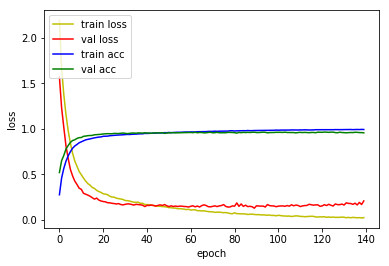

4815/4815 [==============================] - 3s 668us/sample - loss: 0.1835 - acc: 0.9485
Loss: 0.183520101852568 Accuracy: 0.9484943

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8503 - acc: 0.4063
Epoch 00001: val_loss improved from inf to 1.09858, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_9_conv_checkpoint/001-1.0986.hdf5
36805/36805 [==============================] - 57s 2ms/sample - loss: 1.8501 - acc: 0.4064 - val_loss: 1.0986 - val_acc: 0.6869
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1211 - acc: 0.6570
Epoch 00002: val_loss improved from 1.09858 to 0.71458, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_9_conv_checkpoint/002-0.7146.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.1210 - acc: 0.6570 - val_loss: 0.7146 - val_acc: 0.8013
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1353 - acc: 0.9583
Epoch 00023: val_loss improved from 0.12852 to 0.12131, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_075_DO_9_conv_checkpoint/023-0.1213.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1353 - acc: 0.9583 - val_loss: 0.1213 - val_acc: 0.9639
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1344 - acc: 0.9590
Epoch 00024: val_loss did not improve from 0.12131
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1344 - acc: 0.9590 - val_loss: 0.1349 - val_acc: 0.9623
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1258 - acc: 0.9616
Epoch 00025: val_loss did not improve from 0.12131
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1259 - acc: 0.9616 - val_loss: 0.1299 - val_acc: 0.9646
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - l

36800/36805 [============================>.] - ETA: 0s - loss: 0.0472 - acc: 0.9858
Epoch 00051: val_loss did not improve from 0.11494
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0472 - acc: 0.9858 - val_loss: 0.1307 - val_acc: 0.9653
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0461 - acc: 0.9861
Epoch 00052: val_loss did not improve from 0.11494
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0461 - acc: 0.9861 - val_loss: 0.1217 - val_acc: 0.9669
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9871
Epoch 00053: val_loss did not improve from 0.11494
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0421 - acc: 0.9871 - val_loss: 0.1169 - val_acc: 0.9688
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0421 - acc: 0.9869
Epoch 00054: val_loss did not improve from 0.11494
36805/36805 [========================

Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9942
Epoch 00081: val_loss did not improve from 0.11494
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0196 - acc: 0.9942 - val_loss: 0.1395 - val_acc: 0.9674
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0156 - acc: 0.9951
Epoch 00082: val_loss did not improve from 0.11494
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0156 - acc: 0.9951 - val_loss: 0.1447 - val_acc: 0.9693
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9961
Epoch 00083: val_loss did not improve from 0.11494
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0143 - acc: 0.9961 - val_loss: 0.1471 - val_acc: 0.9686
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0169 - acc: 0.9949
Epoch 00084: val_loss did not improve from 0.11494
36805/36805 [===========

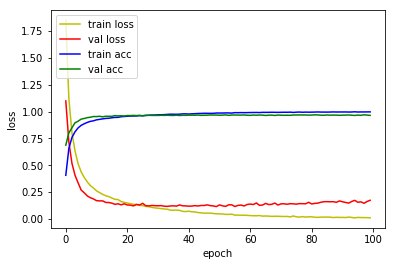

4815/4815 [==============================] - 3s 690us/sample - loss: 0.1663 - acc: 0.9543
Loss: 0.16634295977195598 Accuracy: 0.95430946



In [10]:
for i in range(1, 10):
    base = '1D_CNN_custom_tanh_DO_075_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_tanh_DO_075_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_075_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 369us/sample - loss: 2.7278 - acc: 0.10

4815/4815 [==============================] - 3s 673us/sample - loss: 0.7704 - acc: 0.7707
Loss: 0.7704321701950002 Accuracy: 0.7707165

1D_CNN_custom_tanh_DO_075_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (

4815/4815 [==============================] - 4s 738us/sample - loss: 0.1835 - acc: 0.9485
Loss: 0.183520101852568 Accuracy: 0.9484943

1D_CNN_custom_tanh_DO_075_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_81 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_82 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_83 (Conv1D)           (N

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_tanh_DO'

with open(path.join(log_dir, base+'_last'), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + '000_last.hdf5'

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_075_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 445us/sample - loss: 6.2113 - acc: 0.10

4815/4815 [==============================] - 4s 747us/sample - loss: 0.8659 - acc: 0.7790
Loss: 0.8659318100997592 Accuracy: 0.7790239

1D_CNN_custom_tanh_DO_075_DO_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_60 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_60 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_61 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_61 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_62 (Conv1D)           (

4815/4815 [==============================] - 4s 803us/sample - loss: 0.2849 - acc: 0.9360
Loss: 0.2849020960840357 Accuracy: 0.93603325

1D_CNN_custom_tanh_DO_075_DO_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_81 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_81 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_82 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_83 (Conv1D)           